In [1]:
!wget 'https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt'

--2019-07-25 12:36:45--  https://raw.githubusercontent.com/zaidalyafeai/zaidalyafeai.github.io/master/sketcher/mini_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 760 [text/plain]
Saving to: ‘mini_classes.txt’

mini_classes.txt    100%[===================>]     760  --.-KB/s    in 0s      

2019-07-25 12:36:45 (123 MB/s) - ‘mini_classes.txt’ saved [760/760]



In [0]:
f = open("mini_classes.txt","r")
classes = f.readlines()
classes = [c.replace('\n','').replace(' ','_') for c in classes]
f.close()

In [0]:
# classes

In [0]:
!mkdir data

In [0]:
from fastprogress import progress_bar
import urllib.request
def download():
 
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in progress_bar(classes):
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')


In [10]:
download()

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf


In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
# TAKES some time

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [17]:
print(len(x_train))
print(x_train.shape)
print(y_train.shape)

320000
(320000, 784)
(320000,)


In [0]:
# class_names

drums


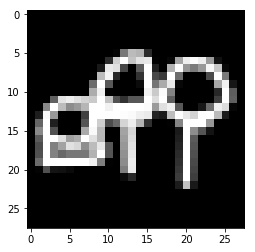

In [25]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  

idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28), cmap="gray") 
print(class_names[int(y_train[idx].item())])

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [28]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((320000, 28, 28, 1), (320000, 100), (80000, 28, 28, 1), (80000, 100))

In [0]:
# ## Model 

# INPUT_SHAPE = (28, 28, 1)
# NUM_CLASSES = 100

# model = keras.Sequential()

# model.add( Input(shape=INPUT_SHAPE, name='input') )
# model.add( Conv2D(24, kernel_size=(6, 6), strides=1) )
# model.add( BatchNormalization(scale=False, beta_initializer=Constant(0.01)) ) 
# model.add( Activation('relu') )

# model.add( Conv2D(48, kernel_size=(5, 5), strides=2) )
# model.add( BatchNormalization(scale=False, beta_initializer=Constant(0.01)) )
# model.add( Activation('relu') )


# model.add( Conv2D(64, kernel_size=(4, 4), strides=2) )
# model.add( BatchNormalization(scale=False, beta_initializer=Constant(0.01)) )
# model.add( Activation('relu') )

# model.add( tf.keras.layers.Flatten() )
# model.add( Dense(200) )
# model.add( BatchNormalization(scale=False, beta_initializer=Constant(0.01)) )
# model.add( Activation('relu'))
# model.add( Dropout(rate=0.25))

# model.add( Dense(NUM_CLASSES, activation='softmax', name='output') )

# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.summary()

In [59]:
# Define model
model = keras.Sequential()
model.add(layers.Input(shape=(28, 28, 1), name='input'))
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu')) # can be removed...
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax', name="output")) 

# Train model
adam = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

In [33]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=1)

Train on 288000 samples, validate on 32000 samples
288000/288000 - 12s - loss: 1.9570 - top_k_categorical_accuracy: 0.7746 - val_loss: 1.3927 - val_top_k_categorical_accuracy: 0.8749


In [34]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10)

Train on 288000 samples, validate on 32000 samples
Epoch 1/10
288000/288000 - 20s - loss: 1.2688 - top_k_categorical_accuracy: 0.8897 - val_loss: 1.1712 - val_top_k_categorical_accuracy: 0.9019
Epoch 2/10
288000/288000 - 7s - loss: 1.1079 - top_k_categorical_accuracy: 0.9076 - val_loss: 1.0913 - val_top_k_categorical_accuracy: 0.9094
Epoch 3/10
288000/288000 - 7s - loss: 1.0180 - top_k_categorical_accuracy: 0.9172 - val_loss: 1.0245 - val_top_k_categorical_accuracy: 0.9164
Epoch 4/10
288000/288000 - 14s - loss: 0.9569 - top_k_categorical_accuracy: 0.9234 - val_loss: 0.9590 - val_top_k_categorical_accuracy: 0.9237
Epoch 5/10
288000/288000 - 19s - loss: 0.9095 - top_k_categorical_accuracy: 0.9279 - val_loss: 0.9492 - val_top_k_categorical_accuracy: 0.9245
Epoch 6/10
288000/288000 - 20s - loss: 0.8757 - top_k_categorical_accuracy: 0.9309 - val_loss: 0.9488 - val_top_k_categorical_accuracy: 0.9252
Epoch 7/10
288000/288000 - 10s - loss: 0.8465 - top_k_categorical_accuracy: 0.9342 - val_loss

In [35]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 92.96%


In [36]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=10)

Train on 288000 samples, validate on 32000 samples
Epoch 1/10
288000/288000 - 7s - loss: 0.7668 - top_k_categorical_accuracy: 0.9415 - val_loss: 0.8723 - val_top_k_categorical_accuracy: 0.9329
Epoch 2/10
288000/288000 - 7s - loss: 0.7532 - top_k_categorical_accuracy: 0.9429 - val_loss: 0.8660 - val_top_k_categorical_accuracy: 0.9334
Epoch 3/10
288000/288000 - 8s - loss: 0.7392 - top_k_categorical_accuracy: 0.9444 - val_loss: 0.8576 - val_top_k_categorical_accuracy: 0.9349
Epoch 4/10
288000/288000 - 7s - loss: 0.7275 - top_k_categorical_accuracy: 0.9454 - val_loss: 0.8689 - val_top_k_categorical_accuracy: 0.9335
Epoch 5/10
288000/288000 - 7s - loss: 0.7175 - top_k_categorical_accuracy: 0.9461 - val_loss: 0.8577 - val_top_k_categorical_accuracy: 0.9334
Epoch 6/10
288000/288000 - 7s - loss: 0.7074 - top_k_categorical_accuracy: 0.9475 - val_loss: 0.8566 - val_top_k_categorical_accuracy: 0.9333
Epoch 7/10
288000/288000 - 7s - loss: 0.6976 - top_k_categorical_accuracy: 0.9480 - val_loss: 0.8

In [37]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.20%


In [0]:
# SAVE AND LOAD MODEL
model.save("quickdraw-acc93.h5")
model.load_weights("quickdraw-acc93.h5")

In [39]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Train on 288000 samples, validate on 32000 samples
Epoch 1/5
288000/288000 - 7s - loss: 0.6689 - top_k_categorical_accuracy: 0.9508 - val_loss: 0.8625 - val_top_k_categorical_accuracy: 0.9337
Epoch 2/5
288000/288000 - 7s - loss: 0.6619 - top_k_categorical_accuracy: 0.9517 - val_loss: 0.8721 - val_top_k_categorical_accuracy: 0.9324
Epoch 3/5
288000/288000 - 7s - loss: 0.6561 - top_k_categorical_accuracy: 0.9521 - val_loss: 0.8591 - val_top_k_categorical_accuracy: 0.9340
Epoch 4/5
288000/288000 - 7s - loss: 0.6510 - top_k_categorical_accuracy: 0.9524 - val_loss: 0.8708 - val_top_k_categorical_accuracy: 0.9334
Epoch 5/5
288000/288000 - 8s - loss: 0.6452 - top_k_categorical_accuracy: 0.9532 - val_loss: 0.8610 - val_top_k_categorical_accuracy: 0.9326


In [40]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 93.10%


['lollipop', 'spoon', 'tennis_racquet', 'screwdriver', 'microphone']


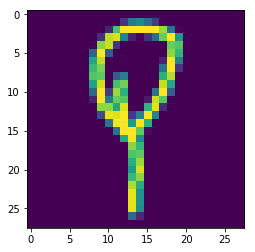

In [75]:
# model.load_weights("quickdraw-acc93.h5")

idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 

pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [0]:
model.save('keras.h5')
# SAVE AND LOAD MODEL
# model.save("quickdraw-acc93.h5")
# model.load_weights("quickdraw-acc93.h5")

In [49]:
# model.save('quickdraw-acc93.h5')
converter = tf.lite.TFLiteConverter.from_keras_model_file('quickdraw-acc93.h5')
tflite_model = converter.convert()
open('quickdraw-acc93.tflite', 'wb').write(tflite_model)

W0725 13:02:58.664932 139761707087744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 13:02:58.667139 139761707087744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0725 13:02:59.790042 139761707087744 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/lite/python/util.py:238: convert_variables_to_constants (from tensorflow.python.framework.graph_util_impl) is

442808

In [0]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [0]:
fname = "quickdraw_labels.json"
import json
with open(fname, 'w') as file_handler:
    file_handler.write( json.dumps({k:v for k,v in enumerate(class_names)})  )

In [0]:
class_names

In [0]:
def show_batch(x_test,y_test):
  idx = [ randint(0, len(x_test)) for i in range(10)]
  fig,axs = plt.subplots(nrows=2, ncols=5, figsize=(9,6))

  for i in range(2):
    for j in range(5):
      pos =  i*j + j 
      img = x_test[idx[pos]]
      ypos = np.argmax(y_test[idx[pos]])
      axs[i,j].set_title( str(ypos) + " " + class_names[ypos] )
      axs[i,j].imshow( img.squeeze() , cmap="gray" )

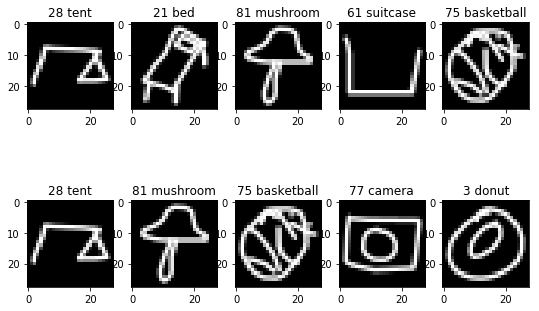

In [98]:
show_batch(x_test, y_test)

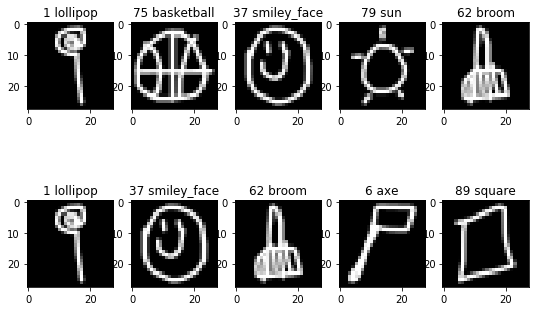

In [99]:
show_batch(x_test, y_test)

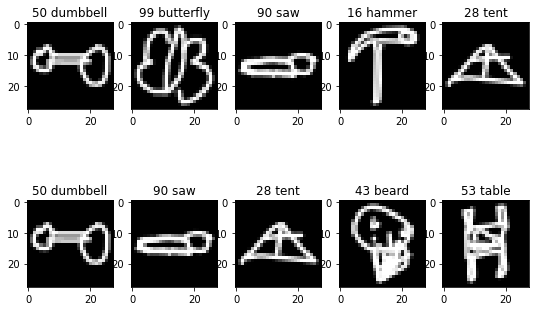

In [100]:
show_batch(x_test, y_test)

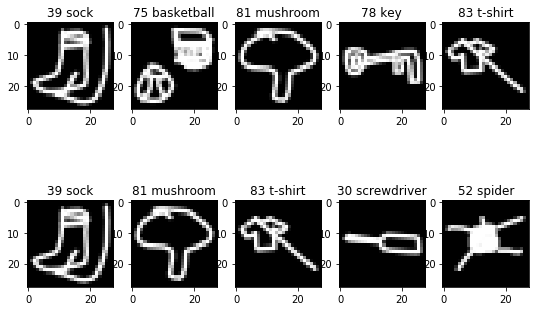

In [101]:
show_batch(x_test, y_test)

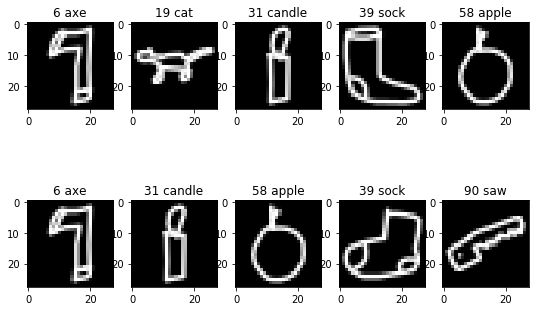

In [102]:
show_batch(x_test, y_test)

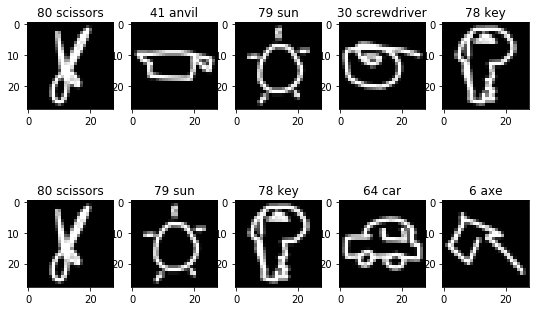

In [103]:
show_batch(x_test, y_test)

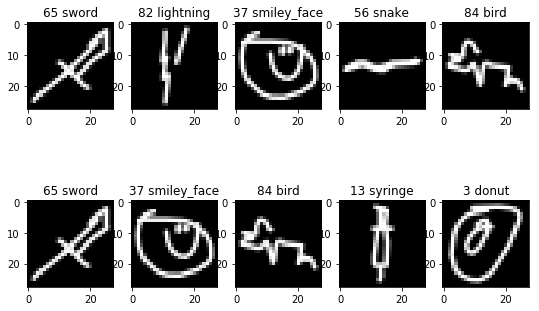

In [104]:
show_batch(x_test, y_test)

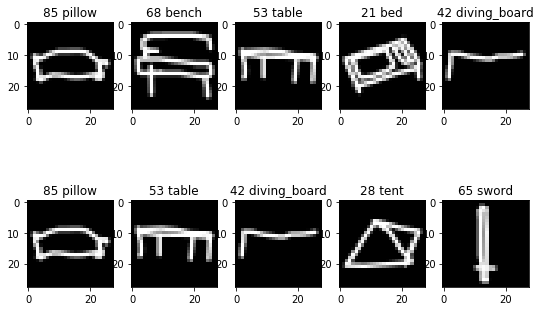

In [105]:
show_batch(x_test, y_test)

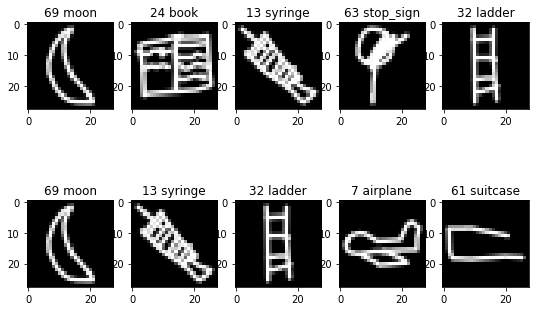

In [106]:
show_batch(x_test, y_test)

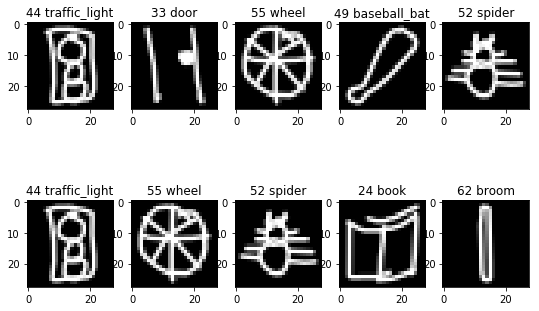

In [107]:
show_batch(x_test, y_test)

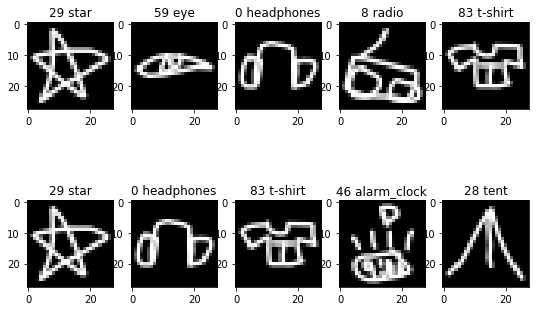

In [108]:
show_batch(x_test, y_test)

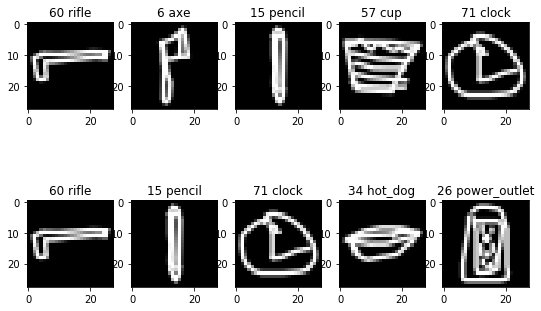

In [109]:
show_batch(x_test, y_test)

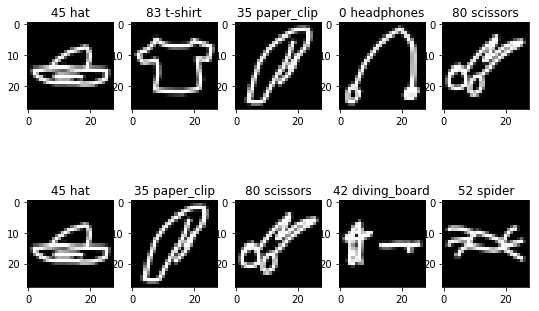

In [110]:
show_batch(x_test, y_test)

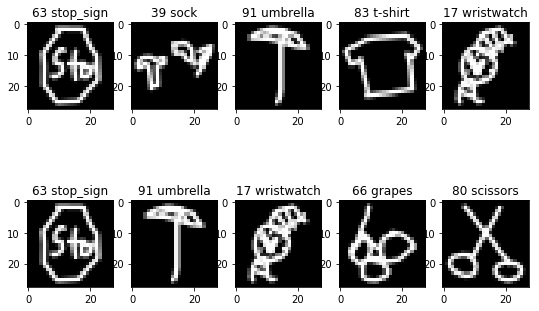

In [111]:
show_batch(x_test, y_test)